In [3]:
from fastbook import *

In [4]:
path = untar_data(URLs.PETS)/'images'
def is_cat(p):
    return p[0].isupper()

dls = ImageDataLoaders.from_name_func(
        path,
        get_image_files(path), valid_pct=0.2, seed=21, label_func=is_cat, item_tfms=Resize(224)
)
learn = cnn_learner(dls, resnet34,metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.134039,0.143941,0.050744,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.071415,0.373830,0.093369,02:16


In [5]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))

In [19]:
x.shape

(1, 3, 224, 224)

In [6]:
class Hook():
    def hook_func(self, m, i, o):
        self.sorted = o.detach().clone()

In [7]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [8]:
with torch.no_grad():
    output = learn.model.eval()(x)

In [9]:
act = hook_output.sorted[0]

In [11]:
hook_output.sorted.shape

(1, 512, 7, 7)

In [12]:
F.softmax(output, dim=-1)

tensor([[4.7566e-09, 1.0000e+00]], device='cuda:0')

In [13]:
x.shape

(1, 3, 224, 224)

In [17]:
learn.model[1][-1].weight.shape

torch.Size([2, 512])

In [18]:
cam_map = torch.einsum('ab,bcd->acd',learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

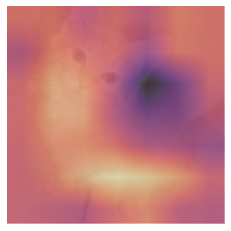

In [22]:
x_decoded = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_decoded.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear',cmap='magma')

In [23]:
hook.remove()

In [24]:
class Hook():
    def __init__(self,m):
        self.hook = m.register_forward_hook(self.hook_func)
        
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
        
    def __enter__(self, *args):
        return self
    
    def __exit__(self,*args):
        self.hook.remove()

In [25]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad():
        output = learn.model.eval()(x.cuda())
    act = hook.stored

In [26]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
        
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
        
    def __enter__(self, *args):
        print(args)
        return self
    
    def __exit__(self, *args):
        print(args)
        self.hook.remove()

In [28]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
        print(output.shape)
    output[0, cls].backward()
    grad = hookg.stored

()
torch.Size([1, 2])
(None, None, None)


In [29]:
grad.shape

torch.Size([1, 512, 7, 7])

In [34]:
w = grad[0].mean((1,2),keepdim=True)
cam_map = (w*act[0]).sum(0)

In [35]:
cam_map.shape, act.shape

((7, 7), (1, 512, 7, 7))

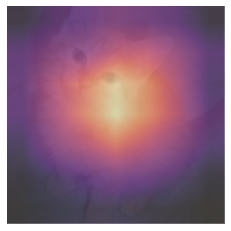

In [38]:
_, ax = plt.subplots()
x_decoded.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear',cmap='magma')

In [40]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as  hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

()
(None, None, None)


In [41]:
w = grad[0].mean(dim=(1,2), keepdim=True)
cam_map = (w * act[0]).sum(0)

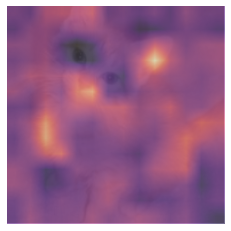

In [42]:
_, ax = plt.subplots()
x_decoded.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear',cmap='magma')